In [1]:
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, Atom
from pmutt.io import gaussian
from pmutt.statmech import StatMech, trans, vib, rot, elec
from pmutt.constants import kb, Na


# interactive plots
%matplotlib widget

In [2]:
KB_KCAL: float = kb("kcal/K")
AVOGADRO: float = Na

KB_KCAL_MOL: float = KB_KCAL * AVOGADRO


## Path father of the inputs

In [3]:
working_directory = Path.cwd() / "../structures"

if not working_directory.exists():
    raise ValueError("The working directory does not exist.")


## Inputs files
* ADF.2013 outputs
* .txt with 2 columns: 1) name of the file of the output adf and 2) ADF energies in Ev
* G16 outputs

In [4]:
list_file_adf = glob(str(working_directory) + "/sozora/*.out")
list_file_g16 = glob(str(working_directory) + "/g16/sddall/*.log")
energies_file_adf = working_directory / ("sozora/energies.txt")

if not energies_file_adf.exists():
    raise ValueError("The energies file does not exist.")

if not list_file_adf:
    raise ValueError("The list of ADF files does not exist.")

if not list_file_g16:
    raise ValueError("The list of G16 files does not exist.")


## Reading coordinates and frequencies from ADF.2013

In [5]:
find_lines_adf = {}
for file_adf in list_file_adf:
    read_file_adf = Path(file_adf).read_text()

    """ Lines to read the geometry and frequencies form ADF.2013 output """
    start_line_geom = None
    last_line_geom = None
    start_line_freq = None
    last_line_freq = None
    for count, line in enumerate(read_file_adf.split("\n")):

        if (
            line
            == "                                            *  F R E Q U E N C I E S  *"
        ):
            start_line_geom = count + 11
        elif line == " Atomic Masses:":
            last_line_geom = count - 3
        elif line == " List of All Frequencies:":
            start_line_freq = count + 9
        elif line == " Statistical Thermal Analysis  ***  ideal gas assumed  ***":
            last_line_freq = count - 4
        elif start_line_geom and last_line_geom and start_line_freq and last_line_freq:
            break
    find_lines_adf[Path(file_adf).stem] = [
        start_line_geom,
        last_line_geom,
        start_line_freq,
        last_line_freq,
    ]

if not find_lines_adf:
    raise ValueError("Geometries and frequencies in ADF.2013 does not exist.")


In [6]:
geoms_systems = {}
freqs_systems = {}
energies_systems = {}
for file_adf in list_file_adf:
    with open(Path(file_adf), "r") as f_adf:
        file_content = f_adf.readlines()

        """Atoms object with ase.Atoms"""
        last_line_geom = find_lines_adf[Path(file_adf).stem][1]
        start_line_geom = find_lines_adf[Path(file_adf).stem][0]
        lines_geom = last_line_geom - start_line_geom
        coord_system = []
        for i in range(lines_geom):
            line = file_content[start_line_geom + i].split()
            coord_system.append(Atom(line[1], (line[5], line[6], line[7])))
        geoms_systems[Path(file_adf).stem] = Atoms(coord_system)

        """Frequencies"""
        last_line_freq = find_lines_adf[Path(file_adf).stem][3]
        start_line_freq = find_lines_adf[Path(file_adf).stem][2]
        lines_freq = last_line_freq - start_line_freq
        freq_system = []
        for i in range(lines_freq):
            line = file_content[start_line_freq + i].split()
            if float(line[0]) > 20.0:
                freq_system.append(float(line[0]))
        freqs_systems[Path(file_adf).stem] = freq_system

    """Energies from ADF.2013 in Ev"""
    with open(energies_file_adf, "r") as f_energies:
        stop = False
        while stop == False:
            line = f_energies.readline().split()
            if line[0] == Path(file_adf).stem:
                energies_systems[Path(file_adf).stem] = float(line[1])
                stop = True

if not geoms_systems:
    raise ValueError("The geometries of the systems does not exist.")
if not freqs_systems:
    raise ValueError("The frequencies of the systems does not exist.")
if not energies_systems:
    raise ValueError("The energies of the systems does not exist.")

geoms_systems["w1s1"].__dict__


{'_cellobj': Cell([0.0, 0.0, 0.0]),
 '_pbc': array([False, False, False]),
 'arrays': {'numbers': array([80,  8,  1,  1]),
  'positions': array([[-0.244886,  0.095186,  0.      ],
         [ 1.858384, -0.18469 ,  0.      ],
         [ 2.317319,  0.18235 ,  0.80465 ],
         [ 2.317319,  0.18235 , -0.80465 ]])},
 '_celldisp': array([[0.],
        [0.],
        [0.]]),
 '_constraints': [],
 'info': {},
 '_calc': None}

## Reading coordinates and frequencies from G16

In [7]:
find_lines_g16 = {}
for file_g16 in list_file_g16:
    read_file_g16 = Path(file_g16).read_text()

    """ Lines to read the geometry form G16 output """
    start_line_geom_g16 = None
    last_line_geom_g16 = None
    for count, line in enumerate(read_file_g16.split("\n")):

        if (
            line
            == "                          Input orientation:                          "
        ):
            start_line_geom_g16 = count + 5
        elif line == "                    Distance matrix (angstroms):":
            last_line_geom_g16 = count - 1
        elif start_line_geom_g16 and last_line_geom_g16:
            break
    find_lines_g16[Path(file_g16).stem] = [start_line_geom_g16, last_line_geom_g16]

if not find_lines_g16:
    raise ValueError("Geometries in G16 does not exist.")


In [8]:
geoms_systems_g16 = {}
freqs_systems_g16 = {}
energies_systems_g16 = {}
for file_g16 in list_file_g16:
    with open(Path(file_g16), "r") as f_g16:
        file_content = f_g16.readlines()

        """Atoms object with ase.Atoms"""
        last_line_geom_g16 = find_lines_g16[Path(file_g16).stem][1]
        start_line_geom_g16 = find_lines_g16[Path(file_g16).stem][0]
        lines_geom_g16 = last_line_geom_g16 - start_line_geom_g16
        coord_system_g16 = []
        for i in range(lines_geom_g16):
            line = file_content[start_line_geom_g16 + i].split()
            coord_system_g16.append(Atom(int(line[1]), (line[3], line[4], line[5])))
        geoms_systems_g16[Path(file_g16).stem] = Atoms(coord_system_g16)

    """Frequencies from G16"""
    freqs_systems_g16[Path(file_g16).stem] = gaussian.read_frequencies(
        file_g16, units="1/cm"
    )
    """Energies from G16 in Ev"""
    energies_systems_g16[Path(file_g16).stem] = gaussian.read_electronic_and_zpe(
        file_g16, units="eV/molecule"
    )

if not geoms_systems_g16:
    raise ValueError("The geometries of the systems does not exist.")
if not freqs_systems_g16:
    raise ValueError("The frequencies of the systems does not exist.")
if not energies_systems_g16:
    raise ValueError("The energies of the systems does not exist.")

geoms_systems_g16["w1s1"].__dict__


{'_cellobj': Cell([0.0, 0.0, 0.0]),
 '_pbc': array([False, False, False]),
 'arrays': {'numbers': array([80,  8,  1,  1]),
  'positions': array([[-0.22513 ,  0.010739,  0.      ],
         [ 1.821376, -0.090165,  0.      ],
         [ 2.325945,  0.18731 ,  0.79892 ],
         [ 2.325945,  0.17731 , -0.79892 ]])},
 '_celldisp': array([[0.],
        [0.],
        [0.]]),
 '_constraints': [],
 'info': {},
 '_calc': None}

## Build object to statical mechanical calculation

In [9]:
translation = {}
vibration = {}
rotation = {}
electronic = {}
translation_g16 = {}
vibration_g16 = {}
rotation_g16 = {}
electronic_g16 = {}
for count, file_adf in enumerate(list_file_adf):
    name_file = Path(file_adf).stem

    """Translational"""
    translation[name_file] = trans.FreeTrans(
        n_degrees=3, atoms=geoms_systems[name_file]
    )
    translation_g16[name_file] = trans.FreeTrans(
        n_degrees=3, atoms=geoms_systems_g16[name_file]
    )

    """Vibrational"""
    vibration[name_file] = vib.HarmonicVib(
        vib_wavenumbers=freqs_systems[name_file]
    )  # cm^-1
    vibration_g16[name_file] = vib.HarmonicVib(
        vib_wavenumbers=freqs_systems_g16[name_file]
    )  # cm^-1

    """Rotational"""
    rotation[name_file] = rot.RigidRotor(
        symmetrynumber=1, atoms=geoms_systems[name_file]
    )  # simmetry point C1
    rotation_g16[name_file] = rot.RigidRotor(
        symmetrynumber=1, atoms=geoms_systems_g16[name_file]
    )  # simmetry point C1

    """Electronic"""
    electronic[name_file] = elec.GroundStateElec(
        potentialenergy=float(energies_systems[name_file]), spin=0
    )  # Ev
    electronic_g16[name_file] = elec.GroundStateElec(
        potentialenergy=float(energies_systems_g16[name_file]), spin=0
    )  # Ev

if not translation and not translation_g16:
    raise ValueError("The translational or _g16 part of the systems does not exist.")
if not vibration and not vibration_g16:
    raise ValueError("The vibrational or _g16 part of the systems does not exist.")
if not rotation and not rotation_g16:
    raise ValueError("The rotational or _g16 part of the systems does not exist.")
if not electronic and not electronic_g16:
    raise ValueError("The electronic or _g16 part of the systems does not exist.")


## Calculate the partition function

In [10]:
statmech = {}
statmech_g16 = {}

for file_adf in list_file_adf:
    name_file = Path(file_adf).stem
    """StatMech Initialization ADF.2013"""
    statmech[name_file] = StatMech(
        name=name_file,
        trans_model=translation[name_file],
        vib_model=vibration[name_file],
        rot_model=rotation[name_file],
        elec_model=electronic[name_file],
    )

    """StatMech Initialization G16"""
    statmech_g16[name_file] = StatMech(
        name=name_file,
        trans_model=translation_g16[name_file],
        vib_model=vibration_g16[name_file],
        rot_model=rotation_g16[name_file],
        elec_model=electronic_g16[name_file],
    )

if not statmech:
    raise ValueError("The statmech does not exist.")
if not statmech_g16:
    raise ValueError("The statmech_g16 does not exist.")


## Thermochemistry quantities

In [11]:
print(
    "systems     H[kcal/mol]    S[kcal/mol/K]    G[kcal/mol]     U[kcal/mol]     T: 298.15 K"
)
for file_adf in list_file_adf:
    name_file = Path(file_adf).stem
    H_statmech = statmech[name_file].get_H(T=298.15, units="kcal/mol")
    S_statmech = statmech[name_file].get_S(T=298.15, units="kcal/mol/K")
    G_statmech = statmech[name_file].get_G(T=298.15, units="kcal/mol")
    U_statmech = statmech[name_file].get_U(T=298.15, units="kcal/mol")
    print(
        f"{name_file}:  {H_statmech:.3f}      {S_statmech:.3f}       {G_statmech:.3f}       {U_statmech:.3f}"
    )


systems     H[kcal/mol]    S[kcal/mol/K]    G[kcal/mol]     U[kcal/mol]     T: 298.15 K
w4s4:  -26361.056      0.120       -26396.900       -26361.649
w5s10:  -26698.196      0.124       -26735.291       -26698.789
w3s1:  -26028.630      0.094       -26056.527       -26029.223
w6s2:  -27059.943      0.126       -27097.591       -27060.536
w3s3:  -25993.364      0.095       -26021.647       -25993.957
w5s8:  -26704.174      0.135       -26744.459       -26704.766
w4s2:  -26376.855      0.112       -26410.296       -26377.448
w5s4:  -26719.385      0.116       -26753.932       -26719.978
w2s1:  -25668.161      0.078       -25691.355       -25668.754
w6s13:  -27048.391      0.135       -27088.590       -27048.983
w6s10:  -27051.053      0.130       -27089.910       -27051.646
w6s1:  -27061.676      0.126       -27099.308       -27062.269
w4s3:  -26370.771      0.108       -26403.000       -26371.363
w6s6:  -27058.503      0.133       -27098.266       -27059.095
w5s7:  -26705.714      0.11

## Thermochemistry quantities: different temperatures in kelvin
* ADF.2013
* G16

In [12]:
initital_temperature = 1
final_temperature = 500
step_temperature = 1


In [19]:
absolute_thermochemistry_per_temperature = {}
absolute_thermochemistry_per_temperature_g16 = {}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    thermo_data = {
        "system": [],
        "H[kcal/mol]": [],
        "S[kcal/mol/K]": [],
        "G[kcal/mol]": [],
    }
    thermo_data_g16 = {
        "system": [],
        "H[kcal/mol]": [],
        "S[kcal/mol/K]": [],
        "G[kcal/mol]": [],
        "U[kcal/mol]": [],
    }

    for file_adf in list_file_adf:
        name_file = Path(file_adf).stem

        """ ADF.2013 """
        H_statmech = statmech[name_file].get_H(T=temperature, units="kcal/mol")
        S_statmech = statmech[name_file].get_S(T=temperature, units="kcal/mol/K")
        G_statmech = statmech[name_file].get_G(T=temperature, units="kcal/mol")
        thermo_data["system"].append(name_file)
        thermo_data["H[kcal/mol]"].append(H_statmech)
        thermo_data["S[kcal/mol/K]"].append(S_statmech)
        thermo_data["G[kcal/mol]"].append(G_statmech)
        """ G16 """
        H_statmech_g16 = statmech_g16[name_file].get_H(T=temperature, units="kcal/mol")
        S_statmech_g16 = statmech_g16[name_file].get_S(
            T=temperature, units="kcal/mol/K"
        )
        G_statmech_g16 = statmech_g16[name_file].get_G(T=temperature, units="kcal/mol")
        thermo_data_g16["system"].append(name_file)
        thermo_data_g16["H[kcal/mol]"].append(H_statmech_g16)
        thermo_data_g16["S[kcal/mol/K]"].append(S_statmech_g16)
        thermo_data_g16["G[kcal/mol]"].append(G_statmech_g16)

    absolute_thermochemistry_per_temperature[temperature] = (
        pd.DataFrame(thermo_data)
        .sort_values(by="system", ascending=True)
        .reset_index(drop=True)
    )
    # absolute_thermochemistry_per_temperature_g16[temperature] = (
    #     pd.DataFrame(thermo_data_g16)
    #     .sort_values(by="system", ascending=True)
    #     .reset_index(drop=True)
    # )


# if not absolute_thermochemistry_per_temperature and not absolute_thermochemistry_per_temperature_g16:
#     raise ValueError(
#         "The absolute thermochemistry or _g16 values of the systems does not exist."
#     )


In [20]:
absolute_thermochemistry_per_temperature[300].


,system,H[kcal/mol],S[kcal/mol/K],G[kcal/mol]
0,w1s1,-25268.398016,0.064358,-25287.705463
1,w2s1,-25668.123925,0.077916,-25691.498634
2,w3s1,-26028.576923,0.093744,-26056.700056
3,w3s2,-26016.880906,0.099007,-26046.582935
4,w3s3,-25993.312458,0.095036,-26021.823151
5,w4s1,-26380.675734,0.101322,-26411.072285
6,w4s2,-26376.785061,0.112397,-26410.504208
7,w4s3,-26370.701897,0.108326,-26403.199750
8,w4s4,-26360.978726,0.120479,-26397.122514
9,w5s1,-26722.901591,0.116717,-26757.916772


In [21]:
minimums_by_cluster = ["w1s1", "w2s1", "w3s1", "w4s1", "w5s1", "w6s1"]


In [22]:
max_number_of_waters = 6

dict_relative_population_delta_H = {
    "system": absolute_thermochemistry_per_temperature[initital_temperature]["system"]
}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    list_of_delta_H = list()

    for water in range(1, max_number_of_waters + 1):

        reference_system = f"w{water}s1"

        H_reference = float(
            absolute_thermochemistry_per_temperature[temperature][
                absolute_thermochemistry_per_temperature[temperature]["system"]
                == reference_system
            ]["H[kcal/mol]"]
        )

        H_values = absolute_thermochemistry_per_temperature[temperature][
            absolute_thermochemistry_per_temperature[temperature][
                "system"
            ].str.startswith(reference_system[:-1])
        ]["H[kcal/mol]"]

        delta_H = H_values - H_reference

        total_delta_H = np.exp(-delta_H / KB_KCAL_MOL / temperature).sum()

        population_delta_H = (
            np.exp(-delta_H / KB_KCAL_MOL / temperature) / total_delta_H
        )

        list_of_delta_H.append(population_delta_H)

    dict_relative_population_delta_H[f"T={temperature}"] = [
        value for sublist in np.array(list_of_delta_H).T for value in sublist
    ]


df_relative_population_delta_H = pd.DataFrame(dict_relative_population_delta_H)


/tmp/ipykernel_270131/1232771593.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value for sublist in np.array(list_of_delta_H).T for value in sublist


In [23]:
max_number_of_waters = 6

dict_relative_population_delta_G = {
    "system": absolute_thermochemistry_per_temperature[initital_temperature]["system"]
}

for temperature in range(initital_temperature, final_temperature, step_temperature):

    list_of_delta_G = list()

    for water in range(1, max_number_of_waters + 1):

        reference_system = f"w{water}s1"

        H_reference = float(
            absolute_thermochemistry_per_temperature[temperature][
                absolute_thermochemistry_per_temperature[temperature]["system"]
                == reference_system
            ]["G[kcal/mol]"]
        )

        H_values = absolute_thermochemistry_per_temperature[temperature][
            absolute_thermochemistry_per_temperature[temperature][
                "system"
            ].str.startswith(reference_system[:-1])
        ]["G[kcal/mol]"]

        delta_G = H_values - H_reference

        total_delta_G = np.exp(-delta_G / KB_KCAL_MOL / temperature).sum()

        population_delta_G = (
            np.exp(-delta_G / KB_KCAL_MOL / temperature) / total_delta_G
        )

        list_of_delta_G.append(population_delta_G)

    dict_relative_population_delta_G[f"T={temperature}"] = [
        value for sublist in np.array(list_of_delta_G).T for value in sublist
    ]


df_relative_population_delta_G = pd.DataFrame(dict_relative_population_delta_G)


/tmp/ipykernel_270131/1717487581.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value for sublist in np.array(list_of_delta_G).T for value in sublist


In [24]:
df_relative_population_delta_G[["system", "T=300"]].tail()


,system,T=300
34,w6s5,0.048303
35,w6s6,0.063644
36,w6s7,0.000442
37,w6s8,0.000149
38,w6s9,0.000001


Text(0, 0.5, 'Relative Population $\\Delta$G')

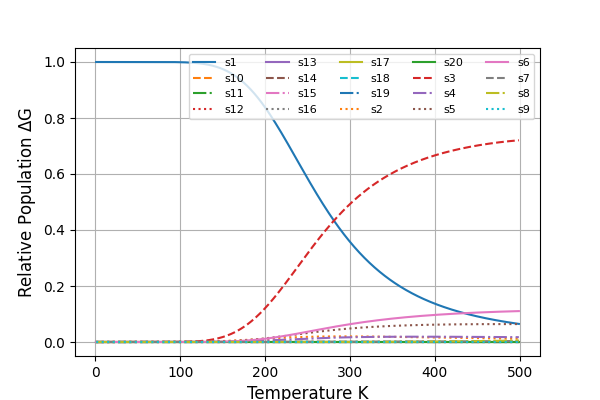

In [25]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


from itertools import cycle
from matplotlib.ticker import MultipleLocator

linecycler = cycle(lines)
cm = cycle(color_palette)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w6s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.xaxis.set_major_locator(MultipleLocator(100))

ax.legend(loc="upper right", fontsize=8, ncol=5)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


Text(0, 0.5, 'Relative Population $\\Delta$G')

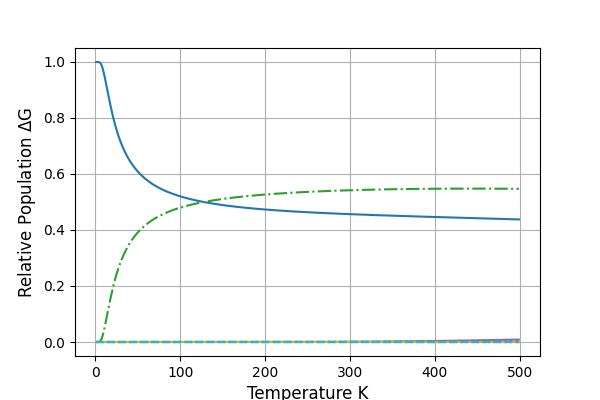

In [26]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

from itertools import cycle

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w5s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )

ax.xaxis.set_major_locator(MultipleLocator(100))
# ax.legend(loc="upper right", fontsize=10, ncol=2)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


Text(0, 0.5, 'Relative Population $\\Delta$G')

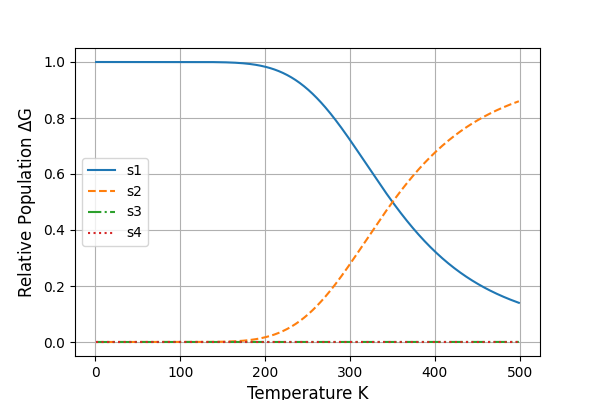

In [27]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

from itertools import cycle

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w4s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )

ax.xaxis.set_major_locator(MultipleLocator(100))


ax.legend(loc="center left", fontsize=10, ncol=1)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)


Text(0, 0.5, 'Relative Population $\\Delta$G')

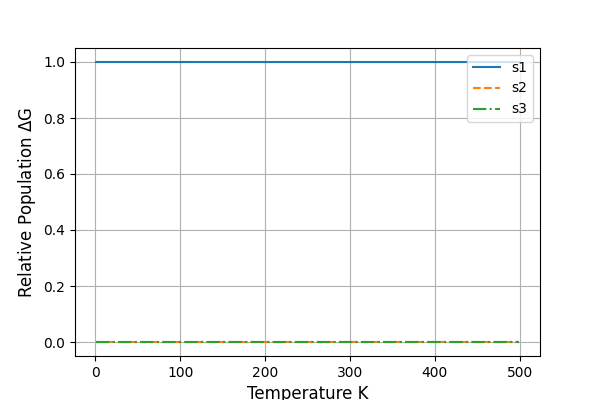

In [28]:
# - lines style in a for loop
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-d', "-.","--",":"]
# lines = ['s', '^', 'v', '<', '>', 'o', 's', 'd', '.'] #, '-h', '-p', '-D', '-H']
# lines = ['-o', '-^', '-v', '-<', '->', '-s', '-+', '-x', '-d', '-1', '-2', '-3', '-4', '-h', '-p', '-|', '-_', '-D', '-H']
lines = ["-", "--", "-.", ":"]

color_palette = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

linecycler = cycle(lines)
cm = cycle(color_palette)

from itertools import cycle

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.grid()

temp = list(range(initital_temperature, final_temperature, step_temperature))
for system in df_relative_population_delta_G["system"]:

    if not system.startswith("w3s"):
        continue

    ax.plot(
        temp,
        df_relative_population_delta_G[
            df_relative_population_delta_G["system"] == system
        ].T.iloc[1:, 0],
        label=system[2:],
        color=next(cm),
        linestyle=next(linecycler),
    )


ax.legend(loc="upper right", fontsize=10, ncol=1)
ax.set_xlabel(r"Temperature K", fontsize=12)
ax.set_ylabel(r"Relative Population $\Delta$G", fontsize=12)
